In [259]:
import pandas as pd
import csv
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import geopandas
from shapely.geometry import Point
import tabulate

gebruikte data: https://outreach.mathstat.strath.ac.uk/outreach/nessie/nessie_whisky.html

In [260]:
whisky = pd.read_csv('whiskies.txt')
whisky

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680
1,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570
2,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320
3,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220
4,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,82,Tobermory,1,1,1,0,0,1,0,0,1,2,2,2,PA75 6NR,150450,755070
82,83,Tomatin,2,3,2,0,0,2,2,1,1,2,0,1,IV13 7YT,279120,829630
83,84,Tomintoul,0,3,1,0,0,2,2,1,1,2,1,2,AB37 9AQ,315100,825560
84,85,Tormore,2,2,1,0,0,1,0,1,2,1,0,0,PH26 3LR,315180,834960


In [261]:
# Relevante features
flavour_profile = whisky.iloc[:,2:14]

Text(0.5, 0, 'Hoeveelheid klassen')

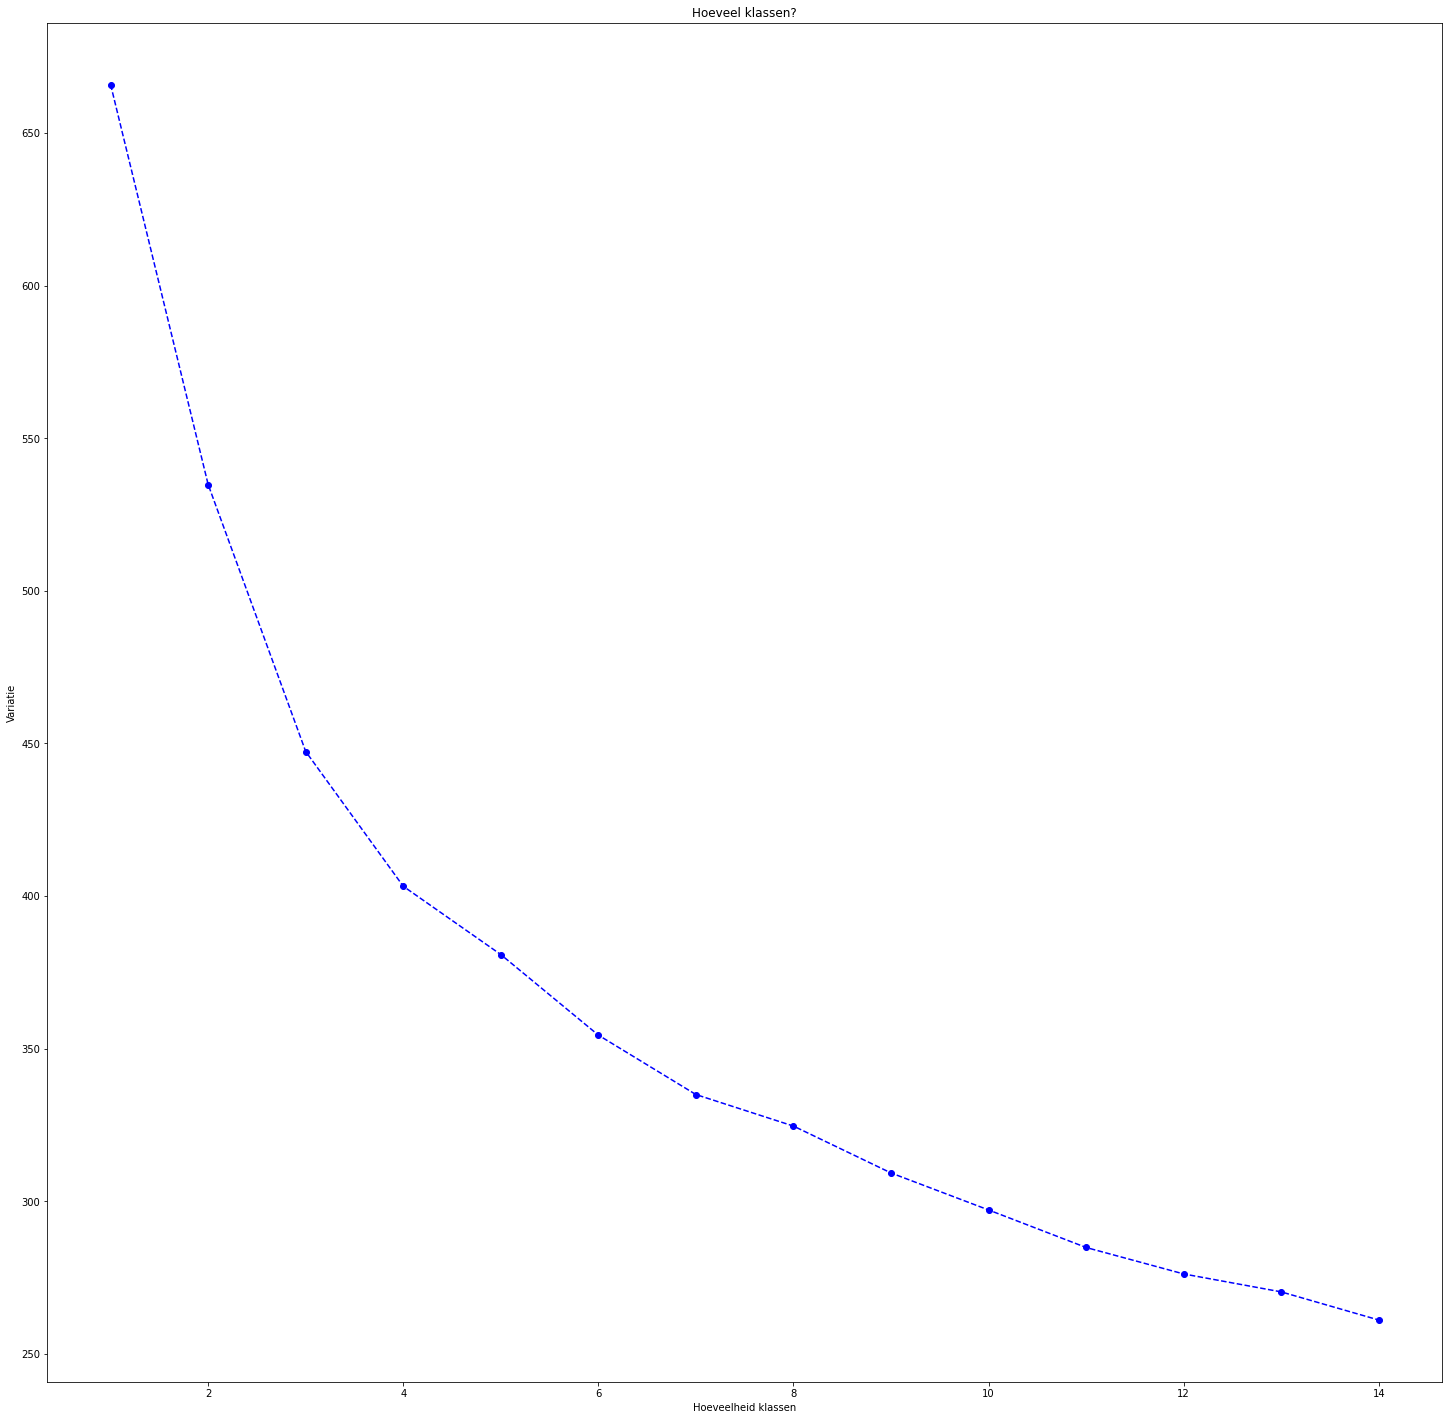

In [262]:
# Kies hoeveelheid clusters
wcss = []
max_clusters = 15
for i in range(1,max_clusters):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(flavour_profile) 
    wcss.append(kmeans.inertia_)
plt.plot(range(1,max_clusters), wcss, '--bo')
plt.title('Hoeveel klassen?')
plt.ylabel('Variatie')
plt.rcParams["figure.figsize"] = (8,5)
plt.xlabel('Hoeveelheid klassen')

In [263]:
# Fit Kmeans met 4 clusters
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(flavour_profile)
whisky['cluster'] = kmeans.predict(flavour_profile)

In [264]:
assignments = pd.DataFrame({'Distillery' :whisky['Distillery'], 'Cluster' : kmeans.predict(flavour_profile)})
assignments

,Distillery,Cluster
0,Aberfeldy,0
1,Aberlour,0
2,AnCnoc,3
3,Ardbeg,2
4,Ardmore,1
...,...,...
81,Tobermory,3
82,Tomatin,1
83,Tomintoul,3
84,Tormore,1


In [265]:
# Fit PCA om data te visualiseren
pca = PCA(n_components=12)
pca.fit(flavour_profile)
components = pca.fit_transform(flavour_profile)
whisky['pca1'] = components.T[0]
whisky['pca2'] = components.T[1]

In [266]:
colordict = {0 : 'blue', 1: 'green', 2: 'purple', 3 : 'red'}
colors = [colordict[cluster] for cluster in whisky['cluster']]
whisky['colors'] = colors

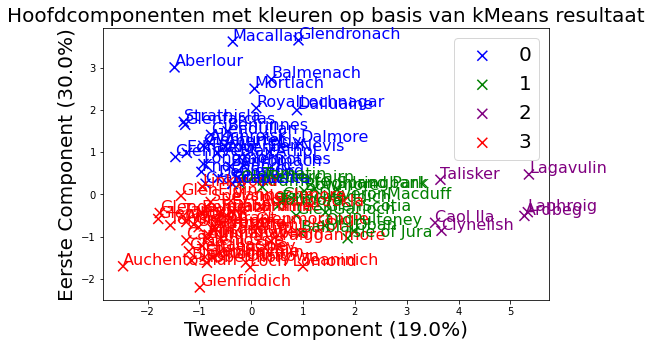

In [267]:
cluster_points = whisky.groupby("cluster")
grouped = zip(cluster_points, ['purple', 'red', 'green', 'yellow'])
for (name, group), colour in grouped:
    plt.scatter(group['pca1'], group['pca2'], label=name, c=group['colors'], marker='x', alpha=1, s=100)
    #plt.annotate(group['Distillery'], xy=(group['pca1'], group['pca2']))
plt.legend(prop={'size': 20})
plt.ylabel(f"Eerste Component ({np.round(pca.explained_variance_ratio_[0], 2)*100}%)", fontsize=20)
plt.xlabel(f"Tweede Component ({np.round(pca.explained_variance_ratio_[1], 2)*100}%)", fontsize=20)
plt.title("Hoofdcomponenten met kleuren op basis van kMeans resultaat", fontsize=20)
for label, cluster, x, y in zip(whisky['Distillery'], whisky['cluster'], whisky['pca1'], whisky['pca2']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(x,y+0.03),color=colordict[cluster], alpha=1, fontsize=16)
plt.rcParams["figure.figsize"] = (25,25)
plt.show()

In [268]:
# Converteer geodata naar breedte/lengtegraad
coords = pd.read_csv('whisky_coords.txt', sep='\s', header = None)
d = {'geometry' : [Point(x, y) for (x,y) in list(zip(coords[0], coords[1]))]}
geo_whisky = geopandas.GeoDataFrame(d, crs=27700)
geo_whisky = geo_whisky.to_crs(4326)
geo_whisky['lon'] = geo_whisky['geometry'].x
geo_whisky['lat'] = geo_whisky['geometry'].y
whisky['lon'] = geo_whisky['lon']
whisky['lat'] = geo_whisky['lat']

/home/luuk/anaconda3/envs/whisky/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [269]:
long_min, long_max = min(whisky['lon']), max(whisky['lon'])
lat_min, lat_max = min(whisky['lat']), max(whisky['lat'])

In [270]:
#Minima/Maxima
BBox = (long_min, long_max, lat_min, lat_max)
BBox

(-6.35936442336857, -2.3169432262781493, 54.85819259852566, 58.96701021656031)

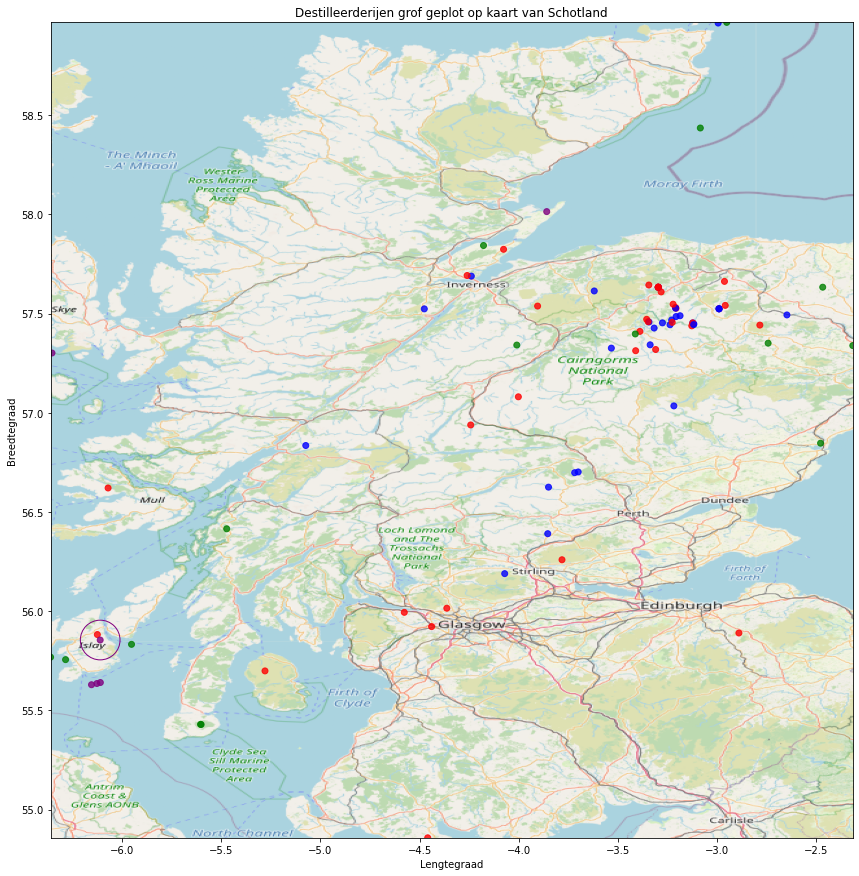

In [279]:
ruh_m = plt.imread('scotland2.png')
fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(whisky['lon'], whisky['lat'], zorder=1, alpha= 0.8, c=whisky['colors'])
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.set_ylabel('Breedtegraad')
circle2 = plt.Circle((whisky.iloc[21]['lon'], whisky.iloc[21]['lat']), 0.1, color='purple', fill=False)
ax.add_patch(circle2)
ax.set_xlabel('Lengtegraad')
ax.set_title('Destilleerderijen grof geplot op kaart van Schotland')
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')

In [272]:
# Wat betekenen de clusters
centroids = pd.DataFrame({i : cluster for i, cluster in enumerate(kmeans.cluster_centers_)}).transpose()
centroids.columns = ['Body', 'Sweetness', 'Smoky', 'Medicinal','Tobacco','Honey','Spicy','Winey','Nutty','Malty','Fruity', 'Floral']

In [194]:
centroids.iloc[:, np.argsort(centroids.loc[1])]
centroids.round(2)

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral
0,2.66,2.41,1.41,0.07,0.03,1.86,1.66,1.79,1.90,2.03,2.10,1.76
1,1.87,1.93,2.07,1.07,0.20,1.13,1.47,0.87,1.53,1.80,1.07,1.13
2,3.67,1.50,3.67,3.33,0.67,0.17,1.67,0.50,1.17,1.33,1.17,0.17
3,1.42,2.47,1.06,0.25,0.06,0.97,1.08,0.44,1.14,1.69,1.97,2.14


In [213]:
# Functie om alle cosinussen te berekenen
def cosine_matrix(v, M):
    # N x features @ features x 1 = N x 1
    numerator = M @ v # dot product of every datapoint with v
    # N x features @ features x N = N x N 
    norms = np.sqrt(np.diag(M @ M.T)) # diagonal of M @ M.T = auto-dotproduct of datapoints -> sqrt= norms (N x 1)
    denominator = norms * np.linalg.norm(v, 2) # multiply by norm of v = denominator (N x 1)
    return numerator / denominator

In [282]:
# De beste whisky
datapoint = np.array([4,0,4,4,3,0,4,0,2,2,0,0])
cosines = cosine_matrix(datapoint, M)
test = (np.argmin(cosines), np.min(cosines))
test

(6, 0.2357022603955158)

In [281]:
kmeans.predict(datapoint.reshape(-1, 1).T)

array([2], dtype=int32)

In [283]:
whisky.iloc[6]

RowID                    7
Distillery    Auchentoshan
Body                     0
Sweetness                2
Smoky                    0
Medicinal                0
Tobacco                  0
Honey                    1
Spicy                    1
Winey                    0
Nutty                    2
Malty                    2
Fruity                   3
Floral                   3
Postcode           G81 4SJ
 Latitude           247670
 Longitude          672610
cluster                  3
pca1             -2.472134
pca2             -1.702369
colors                 red
lon              -4.439339
lat              55.922373
Name: 6, dtype: object

In [211]:
best = whisky.loc[whisky['cluster'] == 2]
best

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,...,Floral,Postcode,Latitude,Longitude,cluster,pca1,pca2,colors,lon,lat
3,4,Ardbeg,4,1,4,4,0,0,2,0,...,0,\tPA42 7EB,141560,646220,2,5.271724,-0.510075,purple,-6.108503,55.640607
21,22,Caol Ila,3,1,4,2,1,0,2,0,...,1,\tPA46 7RL,142920,670040,2,3.547921,-0.673190,purple,-6.109369,55.854804
23,24,Clynelish,3,2,3,3,1,0,2,0,...,0,\tKW9 6LB,290250,904230,2,3.671522,-0.861993,purple,-3.859208,58.013647
57,58,Lagavulin,4,1,4,4,1,0,1,2,...,0,PA42 7DZ,140430,645730,2,5.358250,0.470732,purple,-6.125946,55.635614
58,59,Laphroig,4,2,4,4,1,0,0,1,...,0,PA42 7DU,138680,645160,2,5.336970,-0.421555,purple,-6.153129,55.629569
77,78,Talisker,4,2,3,3,0,1,3,0,...,0,IV47 8SR,137950,831770,2,3.650366,0.345802,purple,-6.352166,57.301051


In [254]:
centroids.to_markdown()

'|    |    Body |   Sweetness |   Smoky |   Medicinal |   Tobacco |    Honey |   Spicy |    Winey |   Nutty |   Malty |   Fruity |   Floral |\n|---:|--------:|------------:|--------:|------------:|----------:|---------:|--------:|---------:|--------:|--------:|---------:|---------:|\n|  0 | 2.65517 |     2.41379 | 1.41379 |   0.0689655 | 0.0344828 | 1.86207  | 1.65517 | 1.7931   | 1.89655 | 2.03448 |  2.10345 | 1.75862  |\n|  1 | 1.86667 |     1.93333 | 2.06667 |   1.06667   | 0.2       | 1.13333  | 1.46667 | 0.866667 | 1.53333 | 1.8     |  1.06667 | 1.13333  |\n|  2 | 3.66667 |     1.5     | 3.66667 |   3.33333   | 0.666667  | 0.166667 | 1.66667 | 0.5      | 1.16667 | 1.33333 |  1.16667 | 0.166667 |\n|  3 | 1.41667 |     2.47222 | 1.05556 |   0.25      | 0.0555556 | 0.972222 | 1.08333 | 0.444444 | 1.13889 | 1.69444 |  1.97222 | 2.13889  |'